# Sky Map

This is based off of (more or less a copy of) code from [Viyaleta Apgar](https://github.com/viyaleta/Python-Demos/blob/main/Sky%20Map%20Demo.ipynb).

In [1]:
from datetime import datetime
from geopy import Nominatim
from tzwhere import tzwhere
from pytz import timezone, utc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle

from skyfield.api import Star, load, wgs84
from skyfield.data import hipparcos
from skyfield.projections import build_stereographic_projection

In [2]:
# load celestial data

# de421 shows position of earth and sun in space
eph = load('de421.bsp')

# hipparcos dataset contains star location data
with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

In [3]:
stars

,magnitude,ra_degrees,dec_degrees,parallax_mas,ra_mas_per_year,dec_mas_per_year,ra_hours,epoch_year
hip,,,,,,,,
1,9.10,0.000912,1.089013,3.54,-5.20,-1.88,0.000061,1991.25
2,9.27,0.003797,-19.498837,21.90,181.21,-0.93,0.000253,1991.25
3,6.61,0.005008,38.859286,2.81,5.24,-2.91,0.000334,1991.25
4,8.06,0.008382,-51.893546,7.75,62.85,0.16,0.000559,1991.25
5,8.55,0.009965,-40.591224,2.87,2.53,9.07,0.000664,1991.25
...,...,...,...,...,...,...,...,...
118318,6.99,359.963744,11.673709,1.92,-2.16,2.09,23.997583,1991.25
118319,8.23,359.973913,-22.428180,10.63,148.74,27.53,23.998261,1991.25
118320,7.59,359.976057,5.956638,5.00,20.92,-35.26,23.998404,1991.25


In [4]:
location = 'Times Square, New York, NY'
when = '2023-01-01 00:00'

In [5]:
# get latitude and longitude of our location 
locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode(location)
lat, long = location.latitude, location.longitude

In [6]:
# convert date string into datetime object
dt = datetime.strptime(when, '%Y-%m-%d %H:%M')

# define datetime and convert to utc based on our timezone
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()
timezone_str = tf.timezone_at(lat=lat, lng=long)
local = timezone(timezone_str)

# get UTC from local timezone and datetime
local_dt = local.localize(dt, is_dst=None)
utc_dt = local_dt.astimezone(utc)

In [7]:
# find location of earth and sun and set the observer position
sun = eph['sun']
earth = eph['earth']

# define observation time from our UTC datetime
ts = load.timescale()
t = ts.from_datetime(utc_dt)

# define an observer using the world geodetic system data
observer = wgs84.latlon(latitude_degrees=lat, longitude_degrees=long).at(t)

# define the position in the sky where we will be looking
position = observer.from_altaz(alt_degrees=90, az_degrees=0)

In [8]:
# center the observation point in the middle of the sky
ra, dec, distance = observer.radec()
center_object = Star(ra=ra, dec=dec)

# find where our center object is relative to earth and build a projection with 180 degree view
center = earth.at(t).observe(center_object)
projection = build_stereographic_projection(center)
field_of_view_degrees = 180.0

# calculate star positions and project them onto a plain space
star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

In [9]:
print(stars['x'][1], stars['y'][1])

1.1340945222692516 0.16290560280226501


Let's assume that the size of our star represents it's relative magnitude.  

Given $F_x$ - the observed irradiance using spectral filter x, and $F_{x,0}$ is the reference flux (zero-point) for that photometric filter, magnitude $m_x$ is 


$$ m_x = -2.5 \cdot log_{10} \big( \frac{F_x}{F_{x,0}} \big)  $$

Let the size of our biggest star in our chart which represents the brightest star be $S_0$ and the size of any star $i$ be represented by $S_i$ and its apparent magnitude be represented by $m_i$. Then,

$$ m_i = -2.5 \cdot log_{10} \big( \frac{S_i}{S_0} \big)  $$

Solving for $S_i$,

$$ S_i = S_0 \cdot 10 ^{m_i/-2.5} $$

In [10]:
chart_size = 10
max_star_size = 100
limiting_magnitude = 10

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]

In [11]:
from astropy.time import Time
from astropy import units as u
from astropy import constants as const
from astropy.visualization import time_support, quantity_support
quantity_support()
time_support()
from astropy.coordinates import SkyCoord, EarthLocation, get_body

In [24]:
deg = u.degree
m = u.meter
location = EarthLocation(lat=41*deg, lon=74*deg, height=131*m)
time = Time(when, location=location)
target = SkyCoord(ra='20h00m00s', dec='+70d00m00s', frame='icrs')
sun = get_body('sun', time)
moon = get_body('moon', time)

target

# sunPos = projection(sun)

print(stars['x'][i], stars['y'][i])

0.4183696617445124 0.47060104500856415


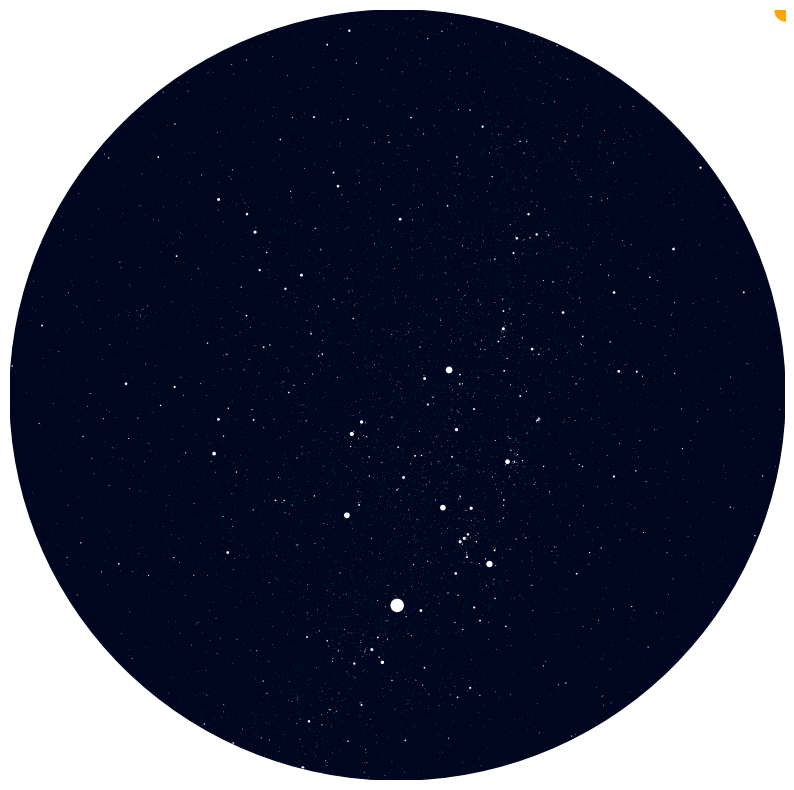

In [20]:
fig, ax = plt.subplots(figsize=(chart_size, chart_size))
    
border = plt.Circle((0, 0), 1, color='#000520', fill=True)
ax.add_patch(border)

marker_size = max_star_size * 10 ** (magnitude / -2.5)

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='white', marker='.', linewidths=0, 
           zorder=2)
plt.plot(1, 1, color='orange', ms=15, marker='o')

horizon = Circle((0, 0), radius=1, transform=ax.transData)
for col in ax.collections:
    col.set_clip_path(horizon)


# other settings
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.axis('off')

plt.show()

### THE PLOT IS CENTRED ON THE OBSERVER'S ZENITH, WHICH IS DEFINED BY THE CARTESIAN (0, 0). SO TO TRANSLATE THE SUN AND MOON POSITIONS, WE FIND THEIR RELATIVE POSITIONS TO THE ZENITH AND TRANSLATE TO CARTESIAN AND NORMALISE.